## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  

For this project, I am trying to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability



In [152]:
# importing the necessary libraries

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

In [153]:
# a. Read in the dataset and take a look at the top few rows here:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. find the number of rows in the dataset.

In [154]:
nrows = df.shape[0]
print(f'the number of rows are: {nrows}'.format(nrows))

the number of rows are: 294478


c. The number of unique users in the dataset.

In [155]:
print('The number of unique users:{}'.format(df['user_id'].nunique()))

The number of unique users:290584


d. The proportion of users converted.

In [156]:
print('Total no. of unique users that converted = {}'.format(df[df['converted']==1]['user_id'].nunique()))
print('Total no of unique users ={}'.format(df['user_id'].nunique()))

print('conversion_rate = {}'.format(df[df['converted']==1]['user_id'].nunique() / df['user_id'].nunique()))

Total no. of unique users that converted = 35173
Total no of unique users =290584
conversion_rate = 0.12104245244060237


e. The number of times the `new_page` and `treatment` don't match.

In [157]:
df.groupby('landing_page')['group'].value_counts()

# so combinations of new_page and control & old_page and treatment are the rows of interest
# so 1928+1965 = 3893

landing_page  group    
new_page      treatment    145311
              control        1928
old_page      control      145274
              treatment      1965
Name: group, dtype: int64

f. Do any of the rows have missing values?

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  We are therefore deleting those rows and creating a new dataset in df2

In [159]:
rows_to_keep_1=df.query('landing_page=="new_page" & group=="treatment"')
rows_to_keep_1.shape

(145311, 5)

In [160]:
rows_to_keep_2=df.query('group=="control" & landing_page =="old_page"')
rows_to_keep_2.shape

(145274, 5)

In [161]:
df2=pd.concat([rows_to_keep_1,rows_to_keep_2])
df2.shape

(290585, 5)

In [162]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions

a. How many unique **user_id**s are in **df2**?

In [163]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [164]:
df2['user_id'].value_counts().head()

#773192 user_id is repeated

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [165]:
df2[df2['user_id']==773192]
# user_id 773192 is present in row no 1899 and row no 2893

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [166]:
df2.shape

(290585, 5)

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [167]:
# dropping row 2893 to remove duplicate user_id
df2.drop([2893], axis=0, inplace=True)

In [168]:
# checking if the row was deleted
df2.shape

# now df has one row less

(290584, 5)

In [169]:
# confirming the duplicate user_id now has only one row
df2['user_id'].value_counts().head()

630732    1
793302    1
840399    1
797392    1
795345    1
Name: user_id, dtype: int64

`4.` Use **df2** in the cells below to answer the quiz questions 

a. What is the probability of an individual converting regardless of the page they receive?

In [170]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [171]:
df2.groupby('group')['converted'].mean()

# for control group, the conversion rate is 0.120386

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [172]:
df2[df2['group']=='treatment']['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [173]:
len(df2[df2['landing_page']=="new_page"])/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Probability of converting regardless of page is 0.1196 or approximately 12%.**

**Given an individual received the control page, the probability of converting is 0.1204 or approximately 12%.**

**Given that an individual received the treatment, the probability of converting is 0.1188 or 12% approximately.**

**Since the probabilities are almost equal, there is no evidence that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$p_{old}$** : The converted rate for the new page is same or less than  the converted rate for the old page

**$p_{new}$** : The converted rate for the new page is greater than the converted rate for the old page

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. What is the **conversion rate** for $p_{new}$ under the null? 

In [174]:
p_new = df2.converted.mean()
print(p_new)

0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [175]:
p_old = df2.converted.mean()
print(p_old)

0.119597087245


c. What is $n_{new}$, the number of individuals in the treatment group?

In [176]:
n_new = df2[df2.landing_page == 'new_page']['user_id'].count()
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [177]:
n_old = df2[df2.landing_page == 'old_page'].user_id.count()
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [178]:
new_page_converted = \
    np.random.choice([0, 1], size=n_new, p=[(1-p_new), p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [179]:
old_page_converted = \
    np.random.choice([0, 1], size=n_old, p=[(1-p_old), p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [180]:
new_page_converted.mean() - old_page_converted.mean()

-0.0013237030388269233

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [181]:
new_converted_simulation = \
    np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = \
    np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

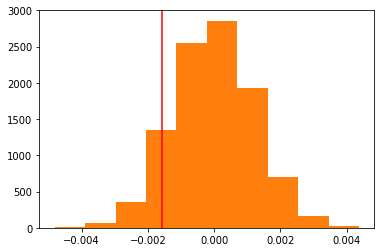

In [182]:
plt.hist(p_diffs)


obs_diff = 0.11880724790277405 - 0.120386

plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [183]:
p_diffs = np.array(p_diffs)
(p_diffs > obs_diff).mean()

0.90229999999999999

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The above histogram contains the sampling distribution under the null hypothesis, which states that the conversion rate of the control group is same as the conversion rate of the treatment group. Part j involves calculating what proportion of the conversion rate differences were greater than the actual observed difference, which was calculated from the conversion rate data. This value is called "p-value".** 

**When p-value is low (specifically, less than our alpha of 0.05) we reject the null hypothesis. Since the p-value is very large at 90%, we fail to reject the null hypothesis. In conclusion, Audacity should keep the current page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [184]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control'].converted.sum()
convert_new = df2[df2['group'] == 'treatment'].converted.sum()
n_old = df2[df2['group'] == 'control'].converted.size
n_new = df2[df2['group'] == 'treatment'].converted.size

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [185]:
from scipy.stats import norm

z_score, p_value = \
    sm.stats.proportions_ztest( [ convert_new, convert_old ], \
                                [ n_new, n_old ], \
                                alternative='larger' )

print('Z-score critical value (95% confidence) to \n' \
      + '    reject the null: ' \
      + str(norm.ppf(1-(0.05/2))))
    
print('z_score = ' + str(z_score))
print('p_value = ' + str(p_value))

Z-score critical value (95% confidence) to 
    reject the null: 1.95996398454
z_score = -1.31092419842
p_value = 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the z-score of 1.31 falls within the range implied by the critical value of 1.96, we fail to reject the null hypothesis. The null hypothesis is that there is difference between the conversion rates for the control group and treatment group.**

**Moreover, since the p_value of 0.90 is greater than the alpha value of 0.05, we fail to reject the null hypothesis.**

**Thus, for the above stated reasons, the built-in method leads to the same conclusion as the manual method**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [186]:
df2['intercept']=1

df2[['zero', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop(['zero'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [187]:
import statsmodels.api as sm

logmod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [188]:
results = logmod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 06 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        16:42:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page in this regression model is 0.19. The p-value that was calculated using the built-in z-test method was  close to 0.90. The p-value calculated using manual calculation also  was around 0.90**

**The null hypothesis associated with a logistic regression is that there is no relationship between which page a user is shown and the conversion rate. So the likelihood of conversion for a user receiving the new page is less than or equal to the likelihood of conversion for a user receiving the old page. The alternative hypothesis would be that there is a relationship of some sort.In other words, the likelihood of conversion for a user receiving the new page is greater than the likelihood of conversion for a user receiving the old page**

**The main reason for the difference in the p-values may be that part II hypothesized that the new_page the treatment group received would lead to more conversions than the other.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**When we add more significant independent variables, we might be able to explain more the variance in the dependent variable. The model will be stronger and we can draw useful insights from the model to help the business make better decisions and strategies.**

**Possible disadvantages include misinterpretation of the coefficients and wrong tweaking of the variables to show the desired results.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [189]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id')\
    .join(df2.set_index('user_id'), how='inner')

In [190]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [191]:
# Identifying the unique values in country variable
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [192]:
# Checking if country has an impact on conversion
df_new.groupby(['country', 'converted']).mean()

intercept   ab_page
country converted                     
CA      0                  1  0.505496
        1                  1  0.488636
UK      0                  1  0.497921
        1                  1  0.500629
US      0                  1  0.501074
        1                  1  0.495933

In [193]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [194]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [195]:
new_logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
new_results = new_logit_mod.fit()
new_results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 06 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        16:42:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [196]:
1/np.exp(0.0506), 1/np.exp(0.0408)

(0.95065885803307093, 0.96002111497165088)

P-values for UK and US both are more than alpha or 0.5. So these are not significant variables.

CA is considered as the baseline. A user based in Canada is 0.95 times likely to convert than a user in UK, holding all other variables constant. Similarly A user based in Canada is 0.96 times likely to convert than a user in US, holding all other variables constant. 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [197]:
# These columns are created to show interaction between country and the ab_page variable

df_new['CA_interaction'] = df_new['ab_page']*df_new['CA']
df_new['UK_interaction'] = df_new['ab_page']*df_new['UK']
df_new['US_interaction'] = df_new['ab_page']*df_new['US']

In [198]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_interaction,UK_interaction,US_interaction
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [199]:
last_logit_model = sm.Logit(df_new['converted'], df_new[['intercept', 'UK_interaction','US_interaction']])
results_log2 = last_logit_model.fit()
results_log2.summary()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 06 May 2019   Pseudo R-squ.:               1.082e-05
Time:                        16:42:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3164
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9926      0.008   -252.910      0.000      -2.008      -1.977
UK_interaction     0.0112      0.018      0.626      0.532      -0.024       0.046
US_interaction    -0.0144      0.012     -1.155      0.248      -0.039       0.010
==================================================================================
"""

**The p-values are very high. The interaction variables are also not significant.**

In [200]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0